In [1]:
## Header files 
# from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2 ##For STrAdaBoost.R2
# from TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2 ## For two-stage TrAdaBoost.R2

import pandas as pd
import sys
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Conv2D, Dropout, Flatten
from keras import optimizers, utils, initializers, regularizers
import keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler #Importing the StandardScaler

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr
from math import sqrt

#Geo plotting libraries
#import geopandas as gdp
#from matplotlib.colors import ListedColormap
#import geoplot as glpt

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
import matplotlib.lines as mlines
import folium
import glob

import statistics
from sklearn.cluster import KMeans
from scipy.spatial import distance

pd.options.display.max_columns = None

from adapt.instance_based import (TrAdaBoost, TrAdaBoostR2, TwoStageTrAdaBoostR2)


print("Done uploading repositories")

Done uploading repositories


In [2]:
############################## UCI Italian dataset #######################################################
## 2 years and single terrain
aqi_df = pd.read_csv('AQI_datasets/UCI_AQI/AirQualityUCI.csv', sep=',', delimiter=";", decimal=",", index_col = None, header=0)

aqi_df.head(20)
# aqi_df.shape
aqi_df.columns

## Predictors: T,Ah,Rh, NMHC_GT, NOx_GT, CO_GT, C6H6_GT ,Target: O3 

Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'NOx_GT', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [3]:
def remove_outlier(col):
    aqi_df[col] = aqi_df.groupby('Date')[col].transform(lambda x: x.fillna(x.mean()))


#drop end rows with NaN values
aqi_df.dropna(how = 'all', inplace = True)

drop_unamed = ['Unnamed: 15', 'Unnamed: 16']
aqi_df = aqi_df.drop(drop_unamed, axis = 1)
aqi_df.columns
print(aqi_df.shape)
aqi_df

#Observing data statistics
aqi_df.describe()

#Drop unwanted columns
drop_uw = ['Time', 'PT08_S1_CO', 'PT08_S2_NMHC', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2']
aqi_df = aqi_df.drop(drop_uw, axis = 1)
aqi_df

#Replace the -200 values seen in the dataset with 
aqi_df.replace(to_replace = -200, value = np.NaN, inplace = True)

#Replace the NaN values with the column mean
col_list = aqi_df.columns[1:]
for i in col_list:
    remove_outlier(i)

aqi_df.fillna(method ='ffill', inplace= True)
aqi_df.dropna(axis = 0)
aqi_df

#Convert 'Date' column to datetime and then seperate out year and month into different columns.
aqi_df.Date = pd.to_datetime(aqi_df.Date)
aqi_df['Year'] = aqi_df['Date'].dt.year
aqi_df['Month'] = aqi_df['Date'].dt.month
drop_date = ['Date']
aqi_df = aqi_df.drop(drop_date, axis = 1)
aqi_df


(9357, 15)


,CO_GT,NMHC_GT,C6H6_GT,NOx_GT,PT08_S5_O3,T,RH,AH,Year,Month
0,2.6,150.0,11.9,166.0,1268.0,13.6,48.9,0.7578,2004,10
1,2.0,112.0,9.4,103.0,972.0,13.3,47.7,0.7255,2004,10
2,2.2,88.0,9.0,131.0,1074.0,11.9,54.0,0.7502,2004,10
3,2.2,80.0,9.2,172.0,1203.0,11.0,60.0,0.7867,2004,10
4,1.6,51.0,6.5,131.0,1110.0,11.2,59.6,0.7888,2004,10
...,...,...,...,...,...,...,...,...,...,...
9352,3.1,275.0,13.5,472.0,1729.0,21.9,29.3,0.7568,2005,4
9353,2.4,275.0,11.4,353.0,1269.0,24.3,23.7,0.7119,2005,4
9354,2.4,275.0,12.4,293.0,1092.0,26.9,18.3,0.6406,2005,4
9355,2.1,275.0,9.5,235.0,770.0,28.3,13.5,0.5139,2005,4


In [15]:
## Get the Spearman Correlation Concrete for the features
aqi_df_corr = aqi_df.copy()
target_uci_col = ['PT08_S5_O3']
aqi_df_corr = aqi_df_corr.drop(target_uci_col, axis = 1)

corr_aqi_df =  aqi_df_corr.corr(method = 'spearman')
corr_aqi_df

corr_aqi_df_lsum = np.tril(corr_aqi_df).sum() - np.trace(corr_aqi_df)
aqi_df_elems = len(corr_aqi_df) * (len(corr_aqi_df) - 1) / 2
corr_aqi_df_lavg = abs(corr_aqi_df_lsum / aqi_df_elems)
corr_aqi_df_lavg

0.07208684590958174

In [29]:
####################### Plot all toxic gases (Not required) ########################################

# aqi_df.drop(['T','RH','AH','Year', 'Month'], axis=1).resample('M').mean().plot(figsize = (20,8))
# plt.legend(loc=1)
# plt.xlabel('Month')
# plt.ylabel('Toxic Gases in the Air')
# plt.title("All Toxic Gases' Frequency by Month");

In [30]:
#Split the dataset according to the year.
aqi_df_2004 = aqi_df[aqi_df['Year'] == 2004]
aqi_df_2005 = aqi_df[aqi_df['Year'] == 2005]

aqi_df_2004 = aqi_df_2004.reset_index(drop=True)
aqi_df_2005 = aqi_df_2005.reset_index(drop=True)


#Divide the dataframe into target and the predictors.
target_uci_col = ['PT08_S5_O3']
aqi_df_2004_target = aqi_df_2004[target_uci_col]
aqi_df_2004_target.columns = ['O3']

aqi_df_2005_target = aqi_df_2005[target_uci_col]
aqi_df_2005_target.columns = ['O3']

### Source Dataset
aqi_df_2004_predictors = aqi_df_2004.drop(target_uci_col, axis = 1)
aqi_df_2004_predictors.columns = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']

### Target Dataset
aqi_df_2005_predictors = aqi_df_2005.drop(target_uci_col, axis = 1)
aqi_df_2005_predictors.columns = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']

print(aqi_df_2004_target.shape, aqi_df_2004_predictors.shape)
print(aqi_df_2005_target.shape, aqi_df_2005_predictors.shape)

aqi_df_2005_target 
aqi_df_2005_predictors


(7110, 1) (7110, 9)
(2247, 1) (2247, 9)


,CO,NMHC,C6H6,NOx,Temp,RH,AH,Year,Month
0,2.134783,275.0,4.2,311.181818,8.2,40.1,0.4375,2005,1
1,1.600000,275.0,8.8,215.000000,5.3,50.7,0.4564,2005,1
2,2.500000,275.0,7.5,300.000000,5.9,50.0,0.4689,2005,1
3,2.700000,275.0,7.6,311.181818,4.9,53.9,0.4693,2005,1
4,1.900000,275.0,5.6,253.000000,4.3,55.3,0.4650,2005,1
...,...,...,...,...,...,...,...,...,...
2242,3.100000,275.0,13.5,472.000000,21.9,29.3,0.7568,2005,4
2243,2.400000,275.0,11.4,353.000000,24.3,23.7,0.7119,2005,4
2244,2.400000,275.0,12.4,293.000000,26.9,18.3,0.6406,2005,4
2245,2.100000,275.0,9.5,235.000000,28.3,13.5,0.5139,2005,4


In [31]:
## Standardize the dataset
columns_uci = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']
cols_to_norm = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH']

ss = StandardScaler()
aqi_df_2004_predictors[cols_to_norm] = ss.fit_transform(aqi_df_2004_predictors[cols_to_norm])
aqi_df_2005_predictors[cols_to_norm] = ss.fit_transform(aqi_df_2005_predictors[cols_to_norm])

aqi_df_2004_predictors
# aqi_df_2005_predictors

,CO,NMHC,C6H6,NOx,Temp,RH,AH,Year,Month
0,0.357434,-1.403072,0.167727,-0.251434,-0.897718,0.030505,-1.028223,2004,10
1,-0.073637,-1.872833,-0.163670,-0.580486,-0.935168,-0.038507,-1.115824,2004,10
2,0.070053,-2.169524,-0.216693,-0.434241,-1.109937,0.323803,-1.048835,2004,10
3,0.070053,-2.268421,-0.190181,-0.220095,-1.222288,0.668860,-0.949843,2004,10
4,-0.361018,-2.626923,-0.548090,-0.434241,-1.197321,0.645856,-0.944148,2004,10
...,...,...,...,...,...,...,...,...,...
7105,-0.648398,0.142195,-0.707160,-0.256657,-1.434508,-0.849390,-2.010003,2004,12
7106,-0.648398,0.142195,-0.707160,-0.256657,-1.397057,-0.924153,-2.033598,2004,12
7107,-0.648398,0.142195,-0.680649,-0.256657,-1.459475,-0.912651,-2.062075,2004,12
7108,-0.648398,0.142195,-0.667393,-0.256657,-1.459475,-0.642356,-1.914537,2004,12


In [32]:
#Splitting dataset into train, test and source.
X_2005_train, X_2005_test, y_2005_train, y_2005_test = train_test_split(aqi_df_2005_predictors, aqi_df_2005_target, test_size = 0.96, random_state = 1)

X_2004 = aqi_df_2004_predictors
y_2004 = aqi_df_2004_target

X_2005_train.shape


(89, 9)

In [33]:
########################################## AdaBoost #####################################################

predictionlist = []
r2scorelist = []
rmselist = []

print("AdaBoost")

for x in range(0, 10):

    np_TF_train_X = X_2005_train.to_numpy()
    np_TF_train_y = y_2005_train.to_numpy()

    np_test_X = X_2005_test.to_numpy()
    np_test_y = y_2005_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_2004), len(X_2005_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators = n_estimators)
    
    regr_2.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred2 = regr_2.predict(np_test_X)
    predictionlist.append(y_pred2)
    
    rmse_adaboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred2))
    print("RMSE of AdaboostR2:", rmse_adaboost)
    rmselist.append(rmse_adaboost)
    
    r2_score_adaboost_values = pearsonr(np_test_y_list, y_pred2)
    r2_score_adaboost = (r2_score_adaboost_values[0])**2
    print("R^2 of AdaboostR2:", r2_score_adaboost)
    r2scorelist.append(r2_score_adaboost)


predict_adaboost = np.mean(predictionlist, axis=0)
list_orginal_adaboost = np_test_y_list

print("mean RMSE of AdaboostR2:", mean(rmselist))
print("mean R^2 of AdaboostR2:", mean(r2scorelist))

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('AdaBoost.R2 Predicted vs Actual')
# # plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
# plt.show()

with open('AQI_datasets/UCI_AQI_Results/O3/AdaBoostOut_R2_std.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/AdaBoostOut_RMSE_std.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/AdaBoostOut_prediction_std.txt', 'w') as filehandle3:
    for listitem in predict_adaboost:
        filehandle3.write('%s\n' % listitem)



AdaBoost
RMSE of AdaboostR2: 183.5902863147077
R^2 of AdaboostR2: 0.8351295795136586
RMSE of AdaboostR2: 182.6919378065448
R^2 of AdaboostR2: 0.8365418707786034
RMSE of AdaboostR2: 183.2971506446896
R^2 of AdaboostR2: 0.8351374464773499
RMSE of AdaboostR2: 184.02558111397323
R^2 of AdaboostR2: 0.8337207818629461
RMSE of AdaboostR2: 181.74608159654906
R^2 of AdaboostR2: 0.8373266218438412
RMSE of AdaboostR2: 180.32427841651773
R^2 of AdaboostR2: 0.84058274921385
RMSE of AdaboostR2: 182.18338806485036
R^2 of AdaboostR2: 0.8384355086349115
RMSE of AdaboostR2: 185.2858246977906
R^2 of AdaboostR2: 0.831995885989319
RMSE of AdaboostR2: 180.40977831902464
R^2 of AdaboostR2: 0.8395032203769454
RMSE of AdaboostR2: 180.09778870754144
R^2 of AdaboostR2: 0.8402613383086137
mean RMSE of AdaboostR2: 182.36520956821892
mean R^2 of AdaboostR2: 0.8368635003000039


In [198]:
########################### Prediction for TrAdaBoost.R2 ##########################################
predictionlist = []
r2scorelist = []
rmselist = []

print("TrAdaBoost.R2")

for x in range(0, 10):

    TF_train_X = pd.concat([X_2004, X_2005_train], sort= False)
    TF_train_y = pd.concat([y_2004, y_2005_train], sort= False)

    np_TF_train_X = TF_train_X.to_numpy()
    np_TF_train_y = TF_train_y.to_numpy()

    np_test_X = X_2005_test.to_numpy()
    np_test_y = y_2005_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_2004), len(X_2005_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    ################################################TrAdaBoost.R2############################################################################
    regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=6), #xgb.XGBRegressor(objective ='reg:squarederror',learning_rate = 0.0001,max_depth = 6,n_estimators = 2000),
                          n_estimators = n_estimators, sample_size = sample_size,
                          steps = steps, fold = fold,
                          random_state = random_state)

    regr_1.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred1 = regr_1.predict(np_test_X)
    predictionlist.append(y_pred1)

    mse_twostageboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred1))
    print("RMSE of TrAdaboostR2:", mse_twostageboost)
    rmselist.append(mse_twostageboost)

    r2_score_twostageboost_values = pearsonr(np_test_y_list, y_pred1)
    r2_score_twostageboost = (r2_score_twostageboost_values[0])**2
    print("R^2 of TrAdaboostR2:", r2_score_twostageboost)
    r2scorelist.append(r2_score_twostageboost)

predict_tradaboost = np.mean(predictionlist, axis=0)
list_orginal_tradaboost = np_test_y_list

print("mean RMSE of TrAdaboostR2:", mean(rmselist))
print("mean R^2 of TrAdaboostR2:", mean(r2scorelist))

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('TrAdaBoost.R2 Predicted vs Actual')
# # plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
# plt.show()

with open('AQI_datasets/UCI_AQI_Results/O3/TrAdaBoostOut_R2_std.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/TrAdaBoostOut_RMSE_std.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/TrAdaBoostOut_prediction_std.txt', 'w') as filehandle3:
    for listitem in predict_tradaboost:
        filehandle3.write('%s\n' % listitem)


TrAdaBoost.R2
RMSE of TrAdaboostR2: 171.6515413016132
R^2 of TrAdaboostR2: 0.8533748798630838
RMSE of TrAdaboostR2: 170.14551538005634
R^2 of TrAdaboostR2: 0.8533157948351648
RMSE of TrAdaboostR2: 170.69377563176536
R^2 of TrAdaboostR2: 0.8534914143838899
RMSE of TrAdaboostR2: 170.23152266767838
R^2 of TrAdaboostR2: 0.8526018221355194
RMSE of TrAdaboostR2: 172.05586024289434
R^2 of TrAdaboostR2: 0.8510481166211975
RMSE of TrAdaboostR2: 169.06705817239322
R^2 of TrAdaboostR2: 0.8554409433731467
RMSE of TrAdaboostR2: 173.20665423910825
R^2 of TrAdaboostR2: 0.848584522950516
RMSE of TrAdaboostR2: 172.54867998954228
R^2 of TrAdaboostR2: 0.8490425791881079
RMSE of TrAdaboostR2: 170.27823788650394
R^2 of TrAdaboostR2: 0.8535451402656496
RMSE of TrAdaboostR2: 170.2347615205619
R^2 of TrAdaboostR2: 0.853871346908591
mean RMSE of TrAdaboostR2: 171.01136070321172
mean R^2 of TrAdaboostR2: 0.8524316560524867


In [136]:
target_column = ['O3']

X_train = pd.read_csv('ActiveSampling/UCI_O3_activesampling_train.csv')
X_test = pd.read_csv('ActiveSampling/UCI_O3_activesampling_test.csv')
X_source = pd.read_csv('ActiveSampling/UCI_O3_activesampling_source.csv')

print(X_train.shape)
print(X_test.shape)
print(X_source.shape)

y_2004 = X_source[target_column]
X_2004 = X_source.drop(target_column, axis = 1)

y_2005_train = X_train[target_column]
X_2005_train = X_train.drop(target_column, axis = 1)

y_2005_test = X_test[target_column]
X_2005_test = X_test.drop(target_column, axis = 1)

X_2005_test

(98, 10)
(2158, 10)
(3600, 10)


,CO,NMHC,C6H6,NOx,Temp,RH,AH,Year,Month
0,-1.122519,0.0,-1.118436,-1.272088,-0.692434,-0.572013,-0.954190,2005,8
1,-1.122519,0.0,-1.118436,-1.080373,-1.301512,0.394126,-0.816529,2005,1
2,1.019686,0.0,1.443230,0.601925,2.120074,-0.295094,2.295396,2005,3
3,0.576471,0.0,0.806695,1.258548,0.525722,-0.178173,0.337425,2005,11
4,-0.900912,0.0,-0.761355,-0.672979,-0.423723,1.151037,0.369745,2005,3
...,...,...,...,...,...,...,...,...,...
2153,-0.974781,0.0,-0.947658,-0.931794,0.651121,-0.885854,-0.245937,2005,2
2154,-0.900912,0.0,-0.994234,-1.142681,1.027316,-0.313555,0.734845,2005,3
2155,2.718677,0.0,3.228634,2.662859,-0.352067,0.480278,-0.010118,2005,1
2156,-1.099435,0.0,-1.196062,-1.329603,-1.265684,0.135668,-0.926259,2005,1


In [101]:
################################# Prediction for STrAdaBoost ##################################################################
predictionlist = []
r2scorelist = []
rmselist = []

print("STrAdaBoost.R2")

for x in range(0, 10):

    TF_train_X = pd.concat([X_2004, X_2005_train], sort= False)
    TF_train_y = pd.concat([y_2004, y_2005_train], sort= False)

    np_TF_train_X = TF_train_X.to_numpy()
    np_TF_train_y = TF_train_y.to_numpy()

    np_test_X = X_2005_test.to_numpy()
    np_test_y = y_2005_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_2004), len(X_2005_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    ################################################STrAdaBoost.R2############################################################################
    regr_1 = STrAdaBoostR2(DecisionTreeRegressor(max_depth=6), #xgb.XGBRegressor(objective ='reg:squarederror',learning_rate = 0.0001,max_depth = 6,n_estimators = 2000),
                          n_estimators = n_estimators, sample_size = sample_size,
                          steps = steps, fold = fold,
                          random_state = random_state)

    regr_1.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred1 = regr_1.predict(np_test_X)
    predictionlist.append(y_pred1)

    mse_twostageboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred1))
    print("RMSE of STrAdaboostR2:", mse_twostageboost)
    rmselist.append(mse_twostageboost)

    r2_score_twostageboost_values = pearsonr(np_test_y_list, y_pred1)
    r2_score_twostageboost = (r2_score_twostageboost_values[0])**2
    print("R^2 of STrAdaboostR2:", r2_score_twostageboost)
    r2scorelist.append(r2_score_twostageboost)

predict_stradaboost = np.mean(predictionlist, axis=0)
list_orginal_stradaboost = np_test_y_list

print("mean RMSE of STrAdaboostR2:", mean(rmselist))
print("mean R^2 of STrAdaboostR2:", mean(r2scorelist))


with open('AQI_datasets/UCI_AQI_Results/O3/STrAdaBoostOut_R2_2.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/STrAdaBoostOut_RMSE_2.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/UCI_AQI_Results/O3/STrAdaBoostOut_prediction_2.txt', 'w') as filehandle3:
    for listitem in predict_stradaboost:
        filehandle3.write('%s\n' % listitem)



plt.scatter(predict_adaboost, list_orginal_adaboost,  c ="red", alpha=0.6)
plt.scatter(predict_tradaboost, list_orginal_tradaboost,  c ="blue", alpha=0.4)
plt.scatter(predict_stradaboost, list_orginal_stradaboost,  c ="green", alpha=0.2)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
# plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
plt.show()


############## How to superimpose scatter plots ########################
## https://stackoverflow.com/questions/11190735/python-matplotlib-superimpose-scatter-plots

STrAdaBoost.R2


NameError: name 'STrAdaBoostR2' is not defined

In [33]:
######################### Gradient Boosting Regression Transfer Learning Italian #######################################
from sklearn.ensemble import GradientBoostingRegressor

print("Gradient Boosting Regression Transfer Learning")
print("-------------------------------------------")

r2scorelist_GBRTL_italian = []
rmselist_GBRTL_italian = []

for x in range(0, 10):
    
    np_TF_train_X = X_2005_train.to_numpy()
    np_TF_train_y = y_2005_train.to_numpy()

    np_test_X = X_2005_test.to_numpy()
    np_test_y = y_2005_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()


    model_GBRTL_italian = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5)
    model_GBRTL_italian.fit(np_TF_train_X, np_TF_train_y_list)

    y_pred_GBRTL_italian = model_GBRTL_italian.predict(np_test_X) ##Using dataframe instead of the numpy matrix

    mse_GBRTL_italian = sqrt(mean_squared_error(np_test_y_list, y_pred_GBRTL_italian))
    rmselist_GBRTL_italian.append(mse_GBRTL_italian)
        
    r2_score_GBRTL_italian = pearsonr(np_test_y_list, y_pred_GBRTL_italian)
    r2_score_GBRTL_italian = (r2_score_GBRTL_italian[0])**2
    r2scorelist_GBRTL_italian.append(r2_score_GBRTL_italian)

print("RMSE of GBR:", statistics.mean(rmselist_GBRTL_italian))
print("R^2 of GBR:", statistics.mean(r2scorelist_GBRTL_italian))
print("\n")
print("RMSE of GBR:", rmselist_GBRTL_italian)
print("R^2 of GBR:", r2scorelist_GBRTL_italian)

print("-------------------------------------------")

Gradient Boosting Regression Transfer Learning
-------------------------------------------
RMSE of GBR: 169.83804568642555
R^2 of GBR: 0.8580780955472149


RMSE of GBR: [172.43722076085052, 171.0841442188501, 167.13597759478478, 168.9832296999789, 169.64656882081957, 168.76243894893932, 169.03423237950398, 170.05147081688312, 170.62779332810234, 170.61738029554294]
R^2 of GBR: [0.8546475807470808, 0.8564545321441435, 0.861665218090882, 0.8585715731331532, 0.8586169771866579, 0.8594151292840027, 0.8589606436645931, 0.8586756229740192, 0.8574898869239121, 0.8562837913237045]
-------------------------------------------


In [5]:
################# UCI Beijing dataset (2013 - 2017) #####################################################################
############### Spacio-temporal dataset. (multi-year and multi-terrain) #################################################

# beijing_aqi_df = pd.read_csv('AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv') 
# drop_index = ['No']
# beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)
# #print(beijing_aqi_df.head())
# print(beijing_aqi_df.isnull().sum())

path_beijing = r'AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/' ## Path for all the files
allFiles = glob.glob(path_beijing + "/*.csv")
beijing_aqi_df = pd.DataFrame()
list_beijing = []
for file_ in allFiles:
    temp_df = pd.read_csv(file_, index_col = None, header=0)
    list_beijing.append(temp_df)
beijing_aqi_df = pd.concat(list_beijing)

cols = ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

beijing_aqi_df = beijing_aqi_df[cols]

drop_index = ['No']
beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)

beijing_aqi_df = beijing_aqi_df.sort_values(['station', 'year'])

# beijing_aqi_df.head(20)
# beijing_aqi_df.year.value_counts()
# beijing_aqi_df.wd.value_counts()
# beijing_aqi_df.shape
# beijing_aqi_df['station'].nunique()
beijing_aqi_df.columns
## O3: Dependent, Predictors: SO2, NO2, year, month, CO
## PM25: Dependent, Predictors:


Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [6]:
######################### Seperate the dataset into predictors and target variable. ###################################

predictors = ['year', 'month', 'SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'O3']
beijing_predictors_df = beijing_aqi_df[predictors]
wd_codes = {'N':1, 'E': 2, 'W': 3, 'S': 4, 'NE': 5, 'NW': 6, 'SE': 7, 'SW': 8, 'NNE': 9, 'NNW': 10, 'SSE': 11, 
            'SSW': 12, 'WNW': 13, 'WSW': 14, 'ENE': 15, 'ESE': 16 }



beijing_predictors_df.replace(wd_codes, inplace=True)
beijing_predictors_df.wd.value_counts()
beijing_predictors_df

# target = ['O3']
# beijing_target_df = beijing_aqi_df[target]
# beijing_target_df

/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,O3
0,2013,3,4.0,7.0,300.0,-0.7,1023.0,-18.8,0.0,10.0,4.4,Aotizhongxin,77.0
1,2013,3,4.0,7.0,300.0,-1.1,1023.2,-18.2,0.0,1.0,4.7,Aotizhongxin,77.0
2,2013,3,5.0,10.0,300.0,-1.1,1023.5,-18.2,0.0,10.0,5.6,Aotizhongxin,73.0
3,2013,3,11.0,11.0,300.0,-1.4,1024.5,-19.4,0.0,6.0,3.1,Aotizhongxin,72.0
4,2013,3,12.0,12.0,300.0,-2.0,1025.2,-19.5,0.0,1.0,2.0,Aotizhongxin,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,3.0,24.0,400.0,12.5,1013.5,-16.2,0.0,6.0,2.4,Wanshouxigong,72.0
35060,2017,2,3.0,41.0,500.0,11.6,1013.6,-15.1,0.0,13.0,0.9,Wanshouxigong,50.0
35061,2017,2,4.0,38.0,500.0,10.8,1014.2,-13.3,0.0,6.0,1.1,Wanshouxigong,54.0
35062,2017,2,4.0,30.0,400.0,10.5,1014.4,-12.9,0.0,10.0,1.2,Wanshouxigong,59.0


In [7]:
############# Replacing missing values ##############################################################
# beijing_predictors_df['SO2'].fillna(beijing_predictors_df['SO2'].median(), inplace=True)
# beijing_predictors_df['NO2'].fillna(beijing_predictors_df['NO2'].mean(), inplace=True)
# beijing_predictors_df['CO'].fillna(beijing_predictors_df['CO'].median(), inplace=True)
# beijing_predictors_df['O3'].fillna(beijing_predictors_df['O3'].median(), inplace=True)
                                   
# beijing_predictors_df = beijing_predictors_df.dropna(axis=0) # , subset=['O3'])

###### percentage of missing values in each column #####################################3
print(round(beijing_predictors_df.isna().sum()/len(beijing_predictors_df.index), 2)*100)

beijing_predictors_df = beijing_predictors_df.dropna()

print(round(beijing_predictors_df.isna().sum()/len(beijing_predictors_df.index), 2)*100)

year       0.0
month      0.0
SO2        2.0
NO2        3.0
CO         5.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
O3         3.0
dtype: float64
year       0.0
month      0.0
SO2        0.0
NO2        0.0
CO         0.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
O3         0.0
dtype: float64


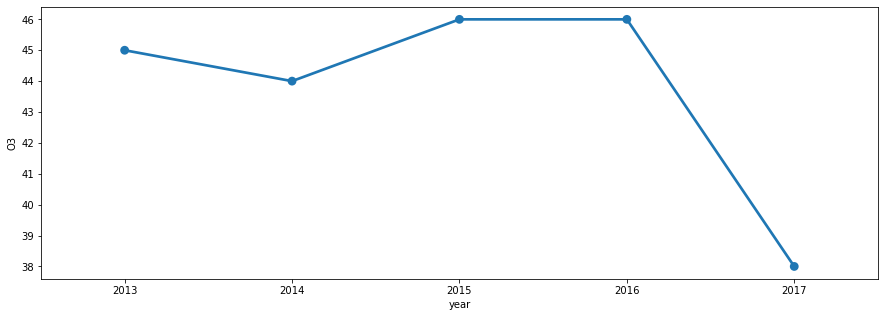

In [8]:
################ plotting concentration of PM 2.5 values over the years ###################################

df_plot_beijing = beijing_predictors_df[['O3','year','station']].groupby(["year"]).median().reset_index().sort_values(by = 'year',ascending=False)
f,ax = plt.subplots(figsize = (15,5))
sns.pointplot(x = 'year', y = 'O3', data = df_plot_beijing)

In [9]:
################# Get correlation between O3 and other predictors. #####################################

# corrMatrix_beijing = beijing_aqi_df.corr()
corrMatrix_beijing = beijing_predictors_df.corr()
corrMatrix_beijing["O3"].sort_values(ascending=False)

# sns.heatmap(corrMatrix_beijing, annot=True)
# plt.show()

O3       1.000000
TEMP     0.597431
DEWP     0.313067
WSPM     0.296701
wd       0.056912
RAIN     0.023375
year    -0.021672
month   -0.101012
SO2     -0.166692
CO      -0.314770
PRES    -0.447751
NO2     -0.476478
Name: O3, dtype: float64

In [10]:
################ Drop stations (dropping stations at this stage so more combination of splits can be made later) #########################
drop_stations = ['station']
beijing_predictors_df = beijing_predictors_df.drop(drop_stations, axis=1)


In [16]:
## Get the Spearman Correlation Concrete for the features

beijing_predictors_df_corr = beijing_predictors_df.copy()
target_beijing_col = ['O3']
beijing_predictors_df_corr = beijing_predictors_df_corr.drop(target_beijing_col, axis = 1)

corr_beijing_predictors_df =  beijing_predictors_df_corr.corr(method = 'spearman')
corr_beijing_predictors_df

corr_beijing_predictors_df_lsum = np.tril(corr_beijing_predictors_df).sum() - np.trace(corr_beijing_predictors_df)
beijing_predictors_df_elems = len(corr_beijing_predictors_df) * (len(corr_beijing_predictors_df) - 1) / 2
corr_beijing_predictors_df_lavg = abs(corr_beijing_predictors_df_lsum / beijing_predictors_df_elems)
corr_beijing_predictors_df_lavg

0.013171122206609615

In [ ]:
################ Splitting the dataset by the year ########################################
beijing_predictors_df.year.value_counts()
beijing_predictors_df_target = beijing_predictors_df[beijing_predictors_df['year'].isin([2014, 2015])]
beijing_predictors_df_source = beijing_predictors_df[beijing_predictors_df['year'].isin([2016])]

print(beijing_predictors_df_source.shape)
print(beijing_predictors_df_target.shape)
# beijing_predictors_df_target.head(10)



In [68]:
########################## Standardize the dataset. #########################################

cols_to_norm = ['SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

ss = StandardScaler()
beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
beijing_predictors_df_source[cols_to_norm] = ss.fit_transform(beijing_predictors_df_source[cols_to_norm])

beijing_predictors_df_source

<ipython-input-68-feb43c26a1e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-68-feb43c26a1e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,O3
24864,2016,1,2.772768,2.280143,3.743354,-1.336244,1.225578,-0.707968,-0.084862,9.0,-0.618369,13.0
24865,2016,1,4.193714,2.160704,3.833436,-1.420293,1.160356,-0.644751,-0.084862,5.0,-0.699815,16.0
24866,2016,1,4.044141,2.041265,2.842532,-1.521150,1.151039,-0.644751,-0.084862,15.0,-0.862708,12.0
24867,2016,1,3.445848,1.921827,2.662368,-1.428697,1.095134,-0.672847,-0.084862,15.0,-0.292584,9.0
24868,2016,1,2.697982,1.802388,2.211957,-1.554769,1.020595,-0.672847,-0.084862,2.0,-0.699815,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33643,2016,12,0.005663,3.175932,3.022697,-1.285816,0.992642,-0.560463,-0.084862,16.0,-0.781261,4.0
33644,2016,12,0.155236,2.966914,2.662368,-1.336244,1.029912,-0.518318,-0.084862,15.0,-0.944154,4.0
33645,2016,12,0.155236,2.817616,2.932615,-1.378269,1.001960,-0.504270,-0.084862,2.0,-0.781261,5.0
33646,2016,12,0.155236,2.310002,3.473108,-1.378269,1.057864,-0.483198,-0.084862,8.0,-1.432832,8.0


In [69]:
##################### Splitting the dataset into train and test set ########################################

target_beijing_col = ['O3']
beijing_predictors_df_target_Y = beijing_predictors_df_target[target_beijing_col]
beijing_predictors_df_target_X = beijing_predictors_df_target.drop(target_beijing_col, axis =1)

beijing_predictors_df_source_Y = beijing_predictors_df_source[target_beijing_col]
beijing_predictors_df_source_X = beijing_predictors_df_source.drop(target_beijing_col, axis =1)


X_train, X_test, y_train, y_test = train_test_split(beijing_predictors_df_target_X, beijing_predictors_df_target_Y, test_size = 0.999, random_state = 1)

X_source = beijing_predictors_df_source_X
y_source = beijing_predictors_df_source_Y

X_train.shape, X_test.shape, X_source.shape, y_train.shape

# X_train.columns

((197, 11), (197331, 11), (99615, 11), (197, 1))

In [70]:
#################################### (Demo) Prediction for AdaBoost #######################################################
predictionlist = []
r2scorelist = []
rmselist = []

print("AdaBoost")

for x in range(0, 10):

    np_TF_train_X = X_train.to_numpy()
    np_TF_train_y = y_train.to_numpy()

    np_test_X = X_test.to_numpy()
    np_test_y = y_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_source), len(X_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators = n_estimators)
    
    regr_2.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred2 = regr_2.predict(np_test_X)
    predictionlist.append(y_pred2)
    
    rmse_adaboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred2))
    print("RMSE of AdaboostR2:", rmse_adaboost)
    rmselist.append(rmse_adaboost)
    
    r2_score_adaboost_values = pearsonr(np_test_y_list, y_pred2)
    r2_score_adaboost = (r2_score_adaboost_values[0])**2
    print("R^2 of AdaboostR2:", r2_score_adaboost)
    r2scorelist.append(r2_score_adaboost)


predict_adaboost = np.mean(predictionlist, axis=0)
list_orginal_adaboost = np_test_y_list

print("mean RMSE of AdaboostR2:", mean(rmselist))
print("mean R^2 of AdaboostR2:", mean(r2scorelist))

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('AdaBoost.R2 Predicted vs Actual')
# # plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
# plt.show()

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_R2_std_999.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_RMSE_std_999.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_prediction_std_999.txt', 'w') as filehandle3:
    for listitem in predict_adaboost:
        filehandle3.write('%s\n' % listitem)




AdaBoost
RMSE of AdaboostR2: 32.532776731519704
R^2 of AdaboostR2: 0.6877995743566426
RMSE of AdaboostR2: 32.87056299620226
R^2 of AdaboostR2: 0.6818912457359528
RMSE of AdaboostR2: 33.209571666985205
R^2 of AdaboostR2: 0.6749755848925322
RMSE of AdaboostR2: 32.803891840326386
R^2 of AdaboostR2: 0.6828800483317818
RMSE of AdaboostR2: 32.905321680189594
R^2 of AdaboostR2: 0.6808104853777054
RMSE of AdaboostR2: 32.56279939323596
R^2 of AdaboostR2: 0.6871231501325993
RMSE of AdaboostR2: 32.62059511292233
R^2 of AdaboostR2: 0.6862144738061179
RMSE of AdaboostR2: 32.90140658387795
R^2 of AdaboostR2: 0.6806879184812922
RMSE of AdaboostR2: 33.22063579056246
R^2 of AdaboostR2: 0.6752377685173588
RMSE of AdaboostR2: 32.85005964211906
R^2 of AdaboostR2: 0.6821784926637742
mean RMSE of AdaboostR2: 32.84776214379409
mean R^2 of AdaboostR2: 0.6819798742295757


In [29]:
#################################### Prediction for AdaBoost #######################################################
predictionlist = []
r2scorelist = []
rmselist = []

print("AdaBoost")

for x in range(0, 10):

    np_TF_train_X = X_train.to_numpy()
    np_TF_train_y = y_train.to_numpy()

    np_test_X = X_test.to_numpy()
    np_test_y = y_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_source), len(X_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators = n_estimators)
    
    regr_2.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred2 = regr_2.predict(np_test_X)
    predictionlist.append(y_pred2)
    
    rmse_adaboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred2))
    print("RMSE of AdaboostR2:", rmse_adaboost)
    rmselist.append(rmse_adaboost)
    
    r2_score_adaboost_values = pearsonr(np_test_y_list, y_pred2)
    r2_score_adaboost = (r2_score_adaboost_values[0])**2
    print("R^2 of AdaboostR2:", r2_score_adaboost)
    r2scorelist.append(r2_score_adaboost)


predict_adaboost = np.mean(predictionlist, axis=0)
list_orginal_adaboost = np_test_y_list

print("mean RMSE of AdaboostR2:", mean(rmselist))
print("mean R^2 of AdaboostR2:", mean(r2scorelist))

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('AdaBoost.R2 Predicted vs Actual')
# # plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
# plt.show()

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_R2_std_999.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_RMSE_std_999.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/AdaBoostOut_prediction_std_999.txt', 'w') as filehandle3:
    for listitem in predict_adaboost:
        filehandle3.write('%s\n' % listitem)



AdaBoost
RMSE of AdaboostR2: 32.6981135277245
R^2 of AdaboostR2: 0.6850750051913875
RMSE of AdaboostR2: 32.73791615469271
R^2 of AdaboostR2: 0.6842065864376252
RMSE of AdaboostR2: 32.99266348767973
R^2 of AdaboostR2: 0.6790249312583293
RMSE of AdaboostR2: 33.03118366747117
R^2 of AdaboostR2: 0.6785077299503172
RMSE of AdaboostR2: 32.86294436598774
R^2 of AdaboostR2: 0.6817944793648458
RMSE of AdaboostR2: 32.794193622188835
R^2 of AdaboostR2: 0.6826820495079257
RMSE of AdaboostR2: 32.688494311486124
R^2 of AdaboostR2: 0.6847141152233336
RMSE of AdaboostR2: 33.20180622738959
R^2 of AdaboostR2: 0.6752643455245851
RMSE of AdaboostR2: 32.72732238986638
R^2 of AdaboostR2: 0.6841200970924285
RMSE of AdaboostR2: 33.282930559146386
R^2 of AdaboostR2: 0.6736955749942777
mean RMSE of AdaboostR2: 32.901756831363315
mean R^2 of AdaboostR2: 0.6809084914545056


In [91]:
########################### Prediction for TrAdaBoost.R2 ##########################################
predictionlist = []
r2scorelist = []
rmselist = []

print("TrAdaBoost.R2")

for x in range(0, 10):

    TF_train_X = pd.concat([X_source, X_train], sort= False)
    TF_train_y = pd.concat([y_source, y_train], sort= False)

    np_TF_train_X = TF_train_X.to_numpy()
    np_TF_train_y = TF_train_y.to_numpy()

    np_test_X = X_test.to_numpy()
    np_test_y = y_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_source), len(X_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    ################################################TrAdaBoost.R2############################################################################
    regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=6), #xgb.XGBRegressor(objective ='reg:squarederror',learning_rate = 0.0001,max_depth = 6,n_estimators = 2000),
                          n_estimators = n_estimators, sample_size = sample_size,
                          steps = steps, fold = fold,
                          random_state = random_state)

    regr_1.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred1 = regr_1.predict(np_test_X)
    predictionlist.append(y_pred1)

    mse_twostageboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred1))
    print("RMSE of TrAdaboostR2:", mse_twostageboost)
    rmselist.append(mse_twostageboost)

    r2_score_twostageboost_values = pearsonr(np_test_y_list, y_pred1)
    r2_score_twostageboost = (r2_score_twostageboost_values[0])**2
    print("R^2 of TrAdaboostR2:", r2_score_twostageboost)
    r2scorelist.append(r2_score_twostageboost)

predict_tradaboost = np.mean(predictionlist, axis=0)
list_orginal_tradaboost = np_test_y_list

print("mean RMSE of TrAdaboostR2:", mean(rmselist))
print("mean R^2 of TrAdaboostR2:", mean(r2scorelist))

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('TrAdaBoost.R2 Predicted vs Actual')
# # plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
# plt.show()

with open('AQI_datasets/Beijing_AQI_Results/O3/TrAdaBoostOut_R2_std_999.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/TrAdaBoostOut_RMSE_std_999.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/TrAdaBoostOut_prediction_std_999.txt', 'w') as filehandle3:
    for listitem in predict_tradaboost:
        filehandle3.write('%s\n' % listitem)


TrAdaBoost.R2
RMSE of TrAdaboostR2: 31.782374170832192
R^2 of TrAdaboostR2: 0.7055145810402719
RMSE of TrAdaboostR2: 31.782368467121945
R^2 of TrAdaboostR2: 0.7055153442700947
RMSE of TrAdaboostR2: 31.781676892702276
R^2 of TrAdaboostR2: 0.7055287480231154
RMSE of TrAdaboostR2: 31.78192822435267
R^2 of TrAdaboostR2: 0.705523263533137
RMSE of TrAdaboostR2: 31.782338730096622
R^2 of TrAdaboostR2: 0.7055162372419563
RMSE of TrAdaboostR2: 31.782938609624683
R^2 of TrAdaboostR2: 0.7055025365414932
RMSE of TrAdaboostR2: 31.78338785552483
R^2 of TrAdaboostR2: 0.7054927167992427
RMSE of TrAdaboostR2: 31.783423923484538
R^2 of TrAdaboostR2: 0.7054919421548778
RMSE of TrAdaboostR2: 31.782923701688297
R^2 of TrAdaboostR2: 0.7055028500690232
RMSE of TrAdaboostR2: 31.782294679362202
R^2 of TrAdaboostR2: 0.705515092997604
mean RMSE of TrAdaboostR2: 31.782565525479026
mean R^2 of TrAdaboostR2: 0.7055103312670816


In [78]:
target_column = ['O3']

X_train = pd.read_csv('ActiveSampling/Beijing_O3_activesampling_train.csv')
X_test = pd.read_csv('ActiveSampling/Beijing_O3_activesampling_test.csv')
X_source = pd.read_csv('ActiveSampling/Beijing_O3_activesampling_source.csv')

print(X_train.shape)
print(X_test.shape)
print(X_source.shape)

y_source = X_source[target_column]
X_source = X_source.drop(target_column, axis = 1)

y_train = X_train[target_column]
X_train = X_train.drop(target_column, axis = 1)

y_test = X_test[target_column]
X_test = X_test.drop(target_column, axis = 1)

X_test

(217, 12)
(197331, 12)
(12000, 12)


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2015,2,0.489557,1.374690,-0.045533,-1.220125,1.196708,-1.206591,-0.078282,8.0,-0.332558
1,2015,4,-0.504288,-1.253593,-0.807620,0.440707,0.286220,-0.509674,-0.078282,13.0,0.401394
2,2015,12,-0.245024,0.470334,1.309289,-1.555826,0.560346,-0.764461,-0.078282,10.0,-0.006357
3,2014,6,-0.633920,-0.744893,-0.384238,0.705733,-0.731959,0.981581,-0.078282,2.0,-0.332558
4,2014,11,1.137716,1.374690,0.293173,-0.407378,1.686217,-0.944311,-0.078282,8.0,-0.903409
...,...,...,...,...,...,...,...,...,...,...,...
197326,2015,12,-0.028971,0.668162,4.696345,-1.043441,0.903002,-0.157468,-0.078282,1.0,-0.658758
197327,2015,6,-0.633920,-0.970982,-0.638267,0.794076,-0.810281,0.869175,-0.078282,8.0,-0.414108
197328,2014,4,-0.158603,0.018157,-0.384238,1.147444,-0.516575,-0.015087,-0.078282,12.0,0.401394
197329,2015,9,-0.633920,-0.660110,-0.722944,0.484878,0.207899,0.599400,-0.078282,9.0,0.646044


In [71]:
################################# Prediction for STrAdaBoost ##################################################################
predictionlist = []
r2scorelist = []
rmselist = []

print("STrAdaBoost.R2")

for x in range(0, 10):

    TF_train_X = pd.concat([X_source, X_train], sort= False)
    TF_train_y = pd.concat([y_source, y_train], sort= False)

    np_TF_train_X = TF_train_X.to_numpy()
    np_TF_train_y = TF_train_y.to_numpy()

    np_test_X = X_test.to_numpy()
    np_test_y = y_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    sample_size = [len(X_source), len(X_train)]
    n_estimators = 100
    steps = 30
    fold = 10
    random_state = np.random.RandomState(1)

    ################################################TrAdaBoost.R2############################################################################
    regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=6), #xgb.XGBRegressor(objective ='reg:squarederror',learning_rate = 0.0001,max_depth = 6,n_estimators = 2000),
                          n_estimators = n_estimators, sample_size = sample_size,
                          steps = steps, fold = fold,
                          random_state = random_state)

    regr_1.fit(np_TF_train_X, np_TF_train_y_list)
    y_pred1 = regr_1.predict(np_test_X)
    predictionlist.append(y_pred1)

    mse_twostageboost = np.sqrt(mean_squared_error(np_test_y_list, y_pred1))
    print("RMSE of STrAdaboostR2:", mse_twostageboost)
    rmselist.append(mse_twostageboost)

    r2_score_twostageboost_values = pearsonr(np_test_y_list, y_pred1)
    r2_score_twostageboost = (r2_score_twostageboost_values[0])**2
    print("R^2 of STrAdaboostR2:", r2_score_twostageboost)
    r2scorelist.append(r2_score_twostageboost)

predict_stradaboost = np.mean(predictionlist, axis=0)
list_orginal_stradaboost = np_test_y_list

with open('AQI_datasets/Beijing_AQI_Results/O3/STrAdaBoostOut_R2_999.txt', 'w') as filehandle1:
    for listitem in r2scorelist:
        filehandle1.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/STrAdaBoostOut_RMSE_999.txt', 'w') as filehandle2:
    for listitem in rmselist:
        filehandle2.write('%s\n' % listitem)

with open('AQI_datasets/Beijing_AQI_Results/O3/STrAdaBoostOut_prediction_999.txt', 'w') as filehandle3:
    for listitem in predict_stradaboost:
        filehandle3.write('%s\n' % listitem)

print("mean RMSE of STrAdaboostR2:", mean(rmselist))
print("mean R^2 of STrAdaboostR2:", mean(r2scorelist))

plt.scatter(predict_adaboost, list_orginal_adaboost,  c ="red", alpha=0.6)
plt.scatter(predict_tradaboost, list_orginal_tradaboost,  c ="blue", alpha=0.4)
plt.scatter(predict_stradaboost, list_orginal_stradaboost,  c ="green", alpha=0.2)


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
# plt.savefig("AQI_datasets/UCI_AQI_Results/NOx/AdaBoostR2_Transfer.png")
plt.show()

############## How to superimpose scatter plots ########################
## https://stackoverflow.com/questions/11190735/python-matplotlib-superimpose-scatter-plots

STrAdaBoost.R2


TypeError: fit() missing 2 required positional arguments: 'src_index' and 'tgt_index'

In [73]:
######################### Gradient Boosting Regression Transfer Learning Beijing #######################################

from sklearn.ensemble import GradientBoostingRegressor

print("Gradient Boosting Regression Transfer Learning")
print("-------------------------------------------")

r2scorelist_GBRTL_beijing = []
rmselist_GBRTL_beijing = []

for x in range(0, 10):
    
    np_TF_train_X = X_train.to_numpy()
    np_TF_train_y = y_train.to_numpy()

    np_test_X = X_test.to_numpy()
    np_test_y = y_test.to_numpy()

    np_TF_train_y_list = np_TF_train_y.ravel()
    np_test_y_list = np_test_y.ravel()

    model_GBRTL_beijing = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.5)
    model_GBRTL_beijing.fit(np_TF_train_X, np_TF_train_y_list)

    y_pred_GBRTL_beijing = model_GBRTL_beijing.predict(np_test_X) ##Using dataframe instead of the numpy matrix

    mse_GBRTL_beijing = sqrt(mean_squared_error(np_test_y_list, y_pred_GBRTL_beijing))
    rmselist_GBRTL_beijing.append(mse_GBRTL_beijing)
        
    r2_score_GBRTL_beijing = pearsonr(np_test_y_list, y_pred_GBRTL_beijing)
    r2_score_GBRTL_beijing = (r2_score_GBRTL_beijing[0])**2
    r2scorelist_GBRTL_beijing.append(r2_score_GBRTL_beijing)

print("RMSE of GBR:", statistics.mean(rmselist_GBRTL_beijing))
print("R^2 of GBR:", statistics.mean(r2scorelist_GBRTL_beijing))
print("\n")
print("RMSE of GBR:", rmselist_GBRTL_beijing)
print("R^2 of GBR:", r2scorelist_GBRTL_beijing)

print("-------------------------------------------")

Gradient Boosting Regression Transfer Learning
-------------------------------------------
RMSE of GBR: 30.62704331502563
R^2 of GBR: 0.7235424307101544


RMSE of GBR: [30.810700956310754, 30.7873418500275, 30.616971280249956, 30.61476165851817, 30.585603389027693, 30.584611670323117, 30.491811949769637, 30.626618109076993, 30.566268584561577, 30.585743702390925]
R^2 of GBR: [0.7200252114892826, 0.720848762462318, 0.7237281909816046, 0.7239303330176193, 0.7241140472249447, 0.7243652028548561, 0.7261891801001833, 0.7234765800989651, 0.7245794270989913, 0.7241673717727796]
-------------------------------------------


In [114]:
##### creating a date column ####################

beijing_aqi_df['date'] = pd.to_datetime(beijing_aqi_df[['year', 'month', 'day']])

drop_date_cols = ['year', 'month', 'day', 'hour']
beijing_aqi_df = beijing_aqi_df.drop(drop_date_cols, axis=1)
beijing_aqi_df.head(10)
beijing_aqi_df.station.counts()

AttributeError: 'Series' object has no attribute 'counts'

In [82]:
######################## Madrid dataset ####################################################################
### Multi-year temporal dataset (multi-year and single terrain)

madrid_2011 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2011.csv")
madrid_2012 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2012.csv") 
madrid_2013 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2013.csv")
madrid_2014 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2014.csv")
madrid_2015 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2015.csv")
madrid_2016 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2016.csv")
madrid_2017 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2017.csv")
madrid_2018 = pd.read_csv("AQI_datasets/Madrid_AQI/madrid_2018.csv")

station = pd.read_csv('AQI_datasets/Madrid_AQI/madrid_stations.csv')
madrid_18_train = pd.concat([madrid_2011,madrid_2012,madrid_2013,madrid_2014,madrid_2015,madrid_2016,madrid_2017], ignore_index=True, sort= True)
                                  
madrid_18_train.head()
madrid_18_train.shape
# # madrid_18_train.columns

# madrid_18_train.station.value_counts()
# madrid_18_train['station'].nunique() ## No. of stations


(1470264, 16)

In [53]:
cols_madrid = ['date', 'station', 'BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY', 'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']
madrid_18_train = madrid_18_train.sort_values(['station', 'date'])
madrid_18_train.head(10)


,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,date,station
69624,NaN,NaN,0.5,NaN,NaN,47.0,36.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2011-01-01 01:00:00,28079004
69648,NaN,NaN,0.6,NaN,NaN,77.0,55.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2011-01-01 02:00:00,28079004
69672,NaN,NaN,0.4,NaN,NaN,18.0,53.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2011-01-01 03:00:00,28079004
69696,NaN,NaN,0.3,NaN,NaN,14.0,41.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2011-01-01 04:00:00,28079004
69720,NaN,NaN,0.3,NaN,NaN,13.0,33.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2011-01-01 05:00:00,28079004
69744,NaN,NaN,0.3,NaN,NaN,13.0,31.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2011-01-01 06:00:00,28079004
69768,NaN,NaN,0.3,NaN,NaN,8.0,22.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2011-01-01 07:00:00,28079004
69792,NaN,NaN,0.3,NaN,NaN,13.0,32.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2011-01-01 08:00:00,28079004
69816,NaN,NaN,0.5,NaN,NaN,79.0,41.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2011-01-01 09:00:00,28079004
69840,NaN,NaN,0.7,NaN,NaN,99.0,35.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2011-01-01 10:00:00,28079004


In [6]:
locations  = station[['lat', 'lon']]
locationlist = locations.values.tolist()

popup = station[['name']]

import folium
map_osm = folium.Map(location = [40.44, -3.69],
                    # tiles='Stamen Toner',
                     zoom_start = 11) 

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup = popup.iloc[point,0]).add_to(map_osm)
    
map_osm

In [84]:
########################## AQI India dataset (2015 - 2020) #############################################
india_df = pd.read_csv('AQI_datasets/India_AQI/city_day.csv')
india_df.head(10)
india_df.shape
# cities_count = india_df['City'].value_counts()
# cities_count

india_df['City'].value_counts()
# india_df['City'].nunique()

Bengaluru             2009
Chennai               2009
Lucknow               2009
Mumbai                2009
Ahmedabad             2009
Delhi                 2009
Hyderabad             2006
Patna                 1858
Gurugram              1679
Visakhapatnam         1462
Amritsar              1221
Jorapokhar            1169
Jaipur                1114
Thiruvananthapuram    1112
Amaravati              951
Brajrajnagar           938
Talcher                925
Kolkata                814
Guwahati               502
Coimbatore             386
Shillong               310
Chandigarh             304
Bhopal                 289
Kochi                  162
Ernakulam              162
Aizawl                 113
Name: City, dtype: int64

In [69]:
################### Counting the total no. of missing values ###########################

# Missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(india_df)
missing_values.style.background_gradient(cmap ='Reds')

Your selected dataframe has 16 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.3
PM10,11140,37.7
NH3,10328,35
Toluene,8041,27.2
Benzene,5623,19
AQI,4681,15.9
AQI_Bucket,4681,15.9
PM2.5,4598,15.6
NOx,4185,14.2
O3,4022,13.6


In [70]:
india_df['Date'] = pd.to_datetime(india_df['Date'])
india_df.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
5,Ahmedabad,2015-01-06,NaN,NaN,45.41,38.48,81.50,NaN,45.41,45.76,46.51,5.42,10.83,1.93,NaN,NaN
6,Ahmedabad,2015-01-07,NaN,NaN,112.16,40.62,130.77,NaN,112.16,32.28,33.47,0.00,0.00,0.00,NaN,NaN
7,Ahmedabad,2015-01-08,NaN,NaN,80.87,36.74,96.75,NaN,80.87,38.54,31.89,0.00,0.00,0.00,NaN,NaN
8,Ahmedabad,2015-01-09,NaN,NaN,29.16,31.00,48.00,NaN,29.16,58.68,25.75,0.00,0.00,0.00,NaN,NaN
9,Ahmedabad,2015-01-10,NaN,NaN,NaN,7.04,0.00,NaN,NaN,8.29,4.55,0.00,0.00,0.00,NaN,NaN


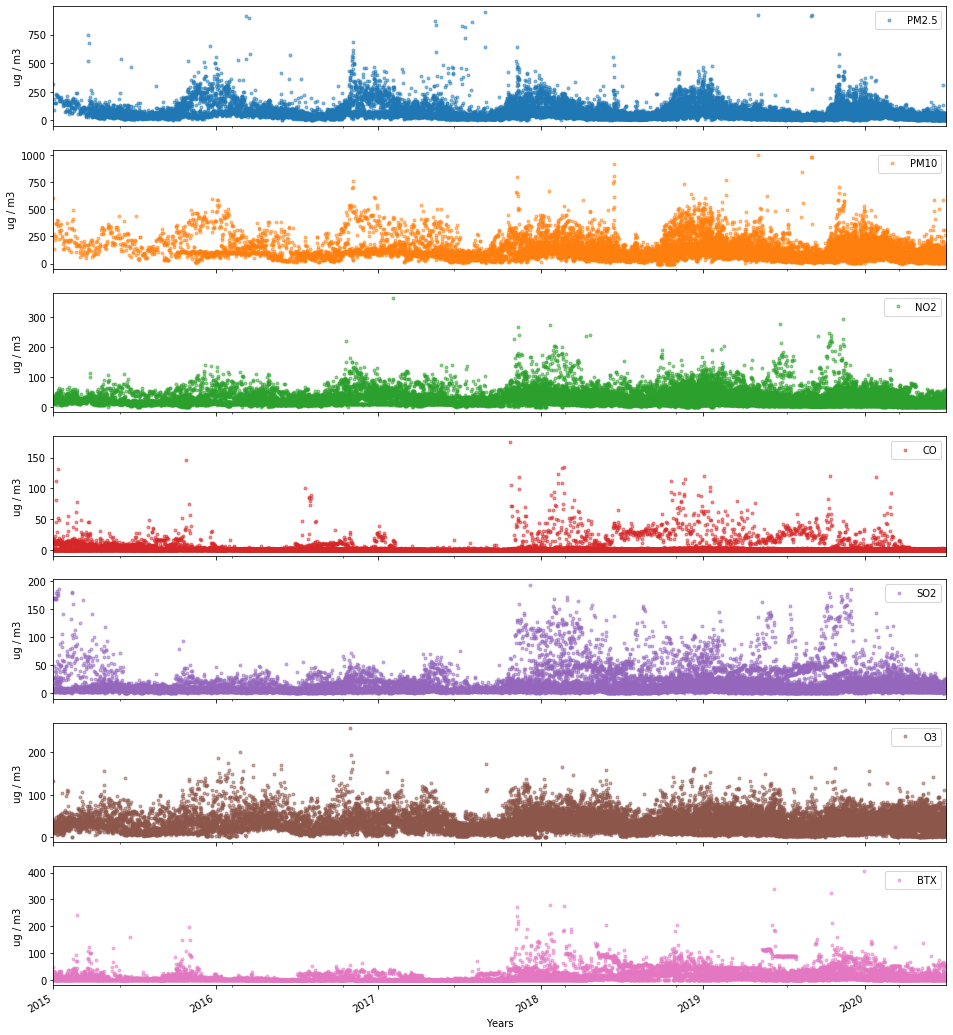

In [71]:
####################### Visualizing growth of pollutants over the years #############################
india_df['BTX'] = india_df['Benzene'] + india_df['Toluene'] + india_df['Xylene']
india_df.drop(['Benzene','Toluene','Xylene'],axis=1)

pollutants = ['PM2.5','PM10','NO2', 'CO', 'SO2','O3', 'BTX']

india_df.set_index('Date', inplace = True)
axes = india_df[pollutants].plot(marker ='.', alpha = 0.5, linestyle ='None', figsize =(16, 20), subplots =True)
for ax in axes:
    
    ax.set_xlabel('Years')
    ax.set_ylabel('ug / m3')

In [138]:
[[2, 3, 9], [1,5,0]] > [[2, 3, 9], [1,2,1]]

True

In [5]:
text = 'the lazy brown dog'

print(text)
print(text.find('f'))
print(text.index('a'))
print(text.isdigit())
print(text.upper())
print(text.replace('brown', 'gray'))
print(text.strip())


the lazy brown dog
-1
5
False
THE LAZY BROWN DOG
the lazy gray dog
the lazy brown dog


In [6]:
def Find(text, character):
    index = 0
    for c in text:
        if c == character:
            return index
        index += 1

print(Find('banana', 'n')) #prints 2


2


In [36]:
"""
Test functions for tradaboost module.
"""

import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from adapt.instance_based import (TrAdaBoost,
                                  TrAdaBoostR2,
                                  TwoStageTrAdaBoostR2)

np.random.seed(0)
Xs = np.concatenate((np.random.randn(50)*0.1, np.random.randn(50)*0.1 + 1.,)).reshape(-1, 1)
Xt = (np.random.randn(100) * 0.1).reshape(-1, 1)
X = np.concatenate((Xs, Xt))
y_reg = np.array([0.2 * x if x<0.5 else 10 for x in X.ravel()])
y_classif = np.array([x<0 if x<0.5 else x<1 for x in X.ravel()]).astype(float)

print(len(Xs))
print(len(y_reg))

def test_setup():
    lr = LinearRegression(fit_intercept=False)
    lr.fit(Xs, y_reg[:100])
    assert np.abs(lr.coef_[0] - 10) < 1
    
    lr = LogisticRegression(penalty='none', solver='lbfgs')
    lr.fit(Xs, y_classif[:100])
    assert (lr.predict(Xt) == y_classif[100:]).sum() < 70


def test_tradaboost_fit():
    np.random.seed(0)
    model = TrAdaBoost(LogisticRegression,
                       n_estimators=20,
                       penalty='none',
                       solver='lbfgs')
    model.fit(X, y_classif, range(100), range(100, 110))
    assert len(model.sample_weights_src_[0]) == 100
    assert (model.sample_weights_src_[0][:50].sum() ==
            model.sample_weights_src_[0][50:].sum())
    assert len(model.sample_weights_tgt_[-1]) == 10
    assert model.sample_weights_tgt_[-1].sum() > 0.7
    assert (model.predict(Xt) == y_classif[100:]).sum() > 90
    
    
def test_tradaboostr2_fit():
    np.random.seed(0)
    model = TrAdaBoostR2(LinearRegression,
                         n_estimators=20,
                         fit_intercept=False)
    model.fit(X, y_reg, range(100), range(100, 110))
    assert np.abs(model.estimators_[-1].coef_[0] - 0.2) < 1
    assert np.abs(model.sample_weights_src_[-1][:50].sum() / 
            model.sample_weights_src_[-1][50:].sum()) > 10
    assert model.sample_weights_tgt_[-1].sum() > 0.7
    assert np.abs(model.predict(Xt).ravel()
                  - y_reg[100:]).sum() < 1


def test_twostagetradaboostr2_fit():
    np.random.seed(0)
    model = TwoStageTrAdaBoostR2(LinearRegression,
                         n_estimators=10,
                         fit_intercept=False)
    model.fit(X, y_reg, range(100), range(100, 110))
    assert np.abs(model.estimators_[-1].estimators_[-1].coef_[0]
           - 0.2) < 1
    assert np.abs(model.sample_weights_src_[-1][:50].sum() / 
            model.sample_weights_src_[-1][50:].sum()) > 10
    assert model.sample_weights_tgt_[-1].sum() > 0.7
    assert np.abs(model.predict(Xt).ravel()
                  - y_reg[100:]).sum() < 1

100
200
